In [1]:
import json
import requests
import urllib.request
import io

from IPython.display import display, Math, Latex, Markdown, clear_output, HTML

import matplotlib.pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from tqdm.notebook import tqdm

from scipy.optimize import curve_fit
from scipy import stats
import numpy as np
import pandas as pd

In [68]:
def get_df(_data, country, what="Confirmed"):
    csv = "data,cases\n"
    for i, l in enumerate(_data[country][what]):
        n = _data[country][what][l]
        csv += f"{l},{n}"
        if i < len(_data[country][what]) - 1:
            csv += "\n"
    data = None
    data = pd.read_csv(io.StringIO(csv),
                         usecols=['data', 'cases'],
                         parse_dates=['data'],
                         index_col=['data'],
                         squeeze=True).sort_index()
    return data

In [3]:
def gompertz_func(x, a, b, k, e):
    exp = - np.exp(k * (b - x))    
    return a * np.exp(exp) + e

In [4]:
def logistic_func(x, a, b, k, e):
    d = k * (b - np.array(x))
    return (a / (1 + np.exp(d))) + e

In [5]:
def double_gompertz(x, a1, b1, k1, a2, b2, k2, e):
    exp1 = - np.exp(k1 * (b1 - x))
    g1 = a1 * np.exp(exp1)
    exp2 = - np.exp(k2 * (b2 - x))
    g2 = (a2 - a1) * np.exp(exp2)
    return g1 + g2 + e

In [6]:
def double_logistic(x, a1, b1, k1, a2, b2, k2, e):
    d1 = k1 * (b1 - np.array(x))
    l1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    l2 = (a2 - a1) / (1 + np.exp(d2))
    return l1 + l2 + e

In [32]:
def prepare_cases(
    cases, forecast=0, country=None,
    method=None, dolog=False):

    popt, pcov = None, None
    
    new_cases = cases.diff()
    max_new_cases = new_cases.argmax()

    if method == "dobgomp":
        p0=[
            cases[max_new_cases] * 2, max_new_cases, 1,
            max(cases), cases.size, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            double_gompertz,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = double_gompertz([i for i in range(cases.size + forecast)], *popt)
        
    elif method == "doblogit":
        p0=[
            cases[max_new_cases], max_new_cases, 1,
            max(cases), cases.size, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            double_logistic,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = double_logistic([i for i in range(cases.size + forecast)], *popt)
        
    elif method == "gomp":
        p0=[
            cases[max_new_cases] * 2, max_new_cases, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            gompertz_func,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = gompertz_func([i for i in range(cases.size + forecast)], *popt)
        
    elif method == "logit":
        p0=[
            cases[max_new_cases], max_new_cases, 1,
            cases[0]
        ]
        popt, pcov = curve_fit(
            logistic_func,
            [i for i in range(cases.size)],
            cases,
            p0=p0, maxfev=8000, method="trf"
        )
        _results = logistic_func([i for i in range(cases.size + forecast)], *popt)
    
#    for i, p in enumerate(p0):
#        print(f"{i} : {p:.2f} - {popt[i]:.2f}")
#    print("-------------------------------------")
    
    forecast_index = pd.date_range(cases.index[0], cases.index[0] + pd.Timedelta(days=len(_results) - 1))
    
    _data = {"data": forecast_index, "valore": _results}
    results = pd.DataFrame(
        data=_data
    ).round()
    
    _cases = {"data": cases.index, "valore": cases.values}
    original = pd.DataFrame(
        data=_cases
    )
    
    _new_cases = {"data": cases.index, "valore": new_cases.values}
    new_cases = pd.DataFrame(
        data=_new_cases
    )

    __new_cases_results = results.diff()
    _new_cases_results = {"data": forecast_index, "valore": __new_cases_results["valore"]}
    new_cases_results = pd.DataFrame(
        data=_new_cases_results
    )
    
    logit1 = None
    logit2 = None
    if dolog:
        poptL1, pcovL1 = curve_fit(
            logistic_func,
            [i for i in range(max_new_cases)],
            cases[:max_new_cases],
            p0=[
                popt[3], max_new_cases, .1, 1
            ],
            method="trf", maxfev=8000
        )

        poptL2, pcovL2 = curve_fit(
            logistic_func,
            [i + max_new_cases for i in range(cases.size - max_new_cases)],
            cases[max_new_cases:],
            p0=[
                popt[3], max_new_cases, .1, 1
            ],
            method="trf", maxfev=8000
        )

        _logistic1 = logistic_func([i for i in range(cases.size + forecast)], *poptL1)
        forecast_index = pd.date_range(cases.index[0], cases.index[0] + pd.Timedelta(days=len(_logistic1) - 1))
        logit1 = pd.Series(
            data=_logistic1, index=forecast_index,
            name=f"{country} cases"
        ).round()

        _logistic2 = logistic_func([i for i in range(cases.size + forecast)], *poptL2)
        forecast_index = pd.date_range(cases.index[0], cases.index[0] + pd.Timedelta(days=len(_logistic2) - 1))
        logit2 = pd.Series(
            data=_logistic2, index=forecast_index,
            name=f"{country} cases"
        ).round()
    
    return original, results, popt, logit1, logit2, new_cases_results, new_cases

In [25]:
url = 'https://raw.githubusercontent.com/maxdevblock/covid-19-time-series/master/json/COVID-COUNTRIES.json'
with urllib.request.urlopen(url) as _url:
    _data = json.loads(_url.read().decode())

In [116]:
country = "Italy"
data = get_df(_data, country)

Text(0.5, 0.98, 'Italy cases forecasts')

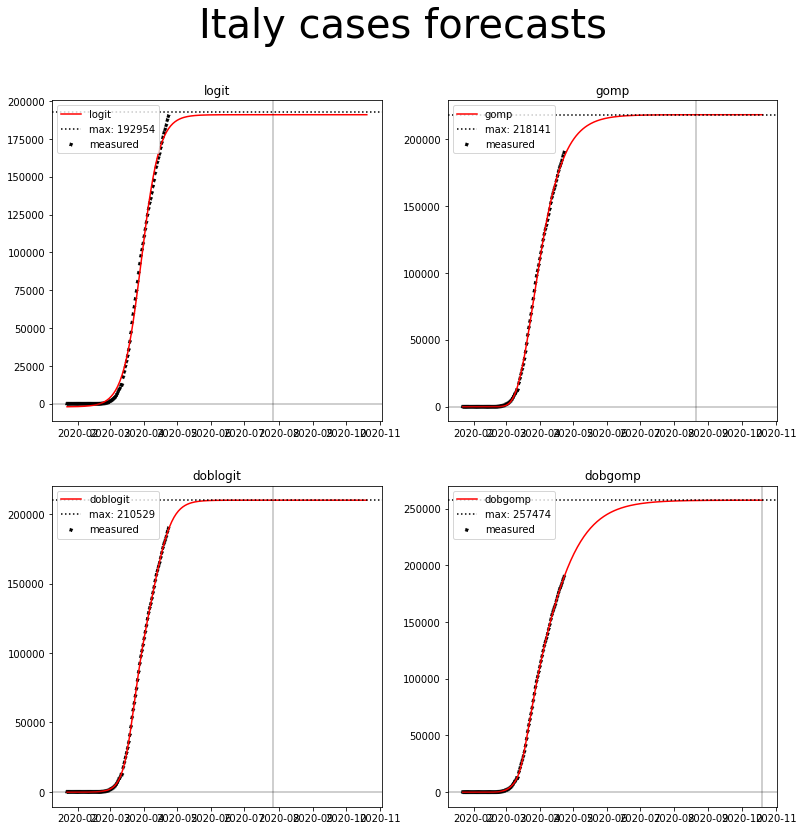

In [152]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, logit1, logit2, new_cases_i, new_cases = prepare_cases(data, forecast=180, country=country, method=f)
    axs.flat[i].scatter(
        original["data"],
        original["valore"],
        ls=":", s=10,
        label="measured", c="k"
    )
    axs.flat[i].plot(
        interp["data"],
        interp["valore"],
        c="r",
        label=f
    )
    axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    axs.flat[i].legend(loc="upper left")
    axs.flat[i].set_title(f)
    axs.flat[i].axhline(0, c="k", alpha=.25)
    news = new_cases_i.iloc[new_cases_i.index > new_cases.size]
    zeros = news.iloc[news["valore"].values == 0]
    zero = zeros["data"].values[0]
    axs.flat[i].axvline(zero, c="k", alpha=.25)
fig.suptitle("Italy cases forecasts", fontsize=40)

numpy.datetime64('2020-10-20T00:00:00.000000000')

Text(0.5, 0.98, 'Italy new cases forecasts')

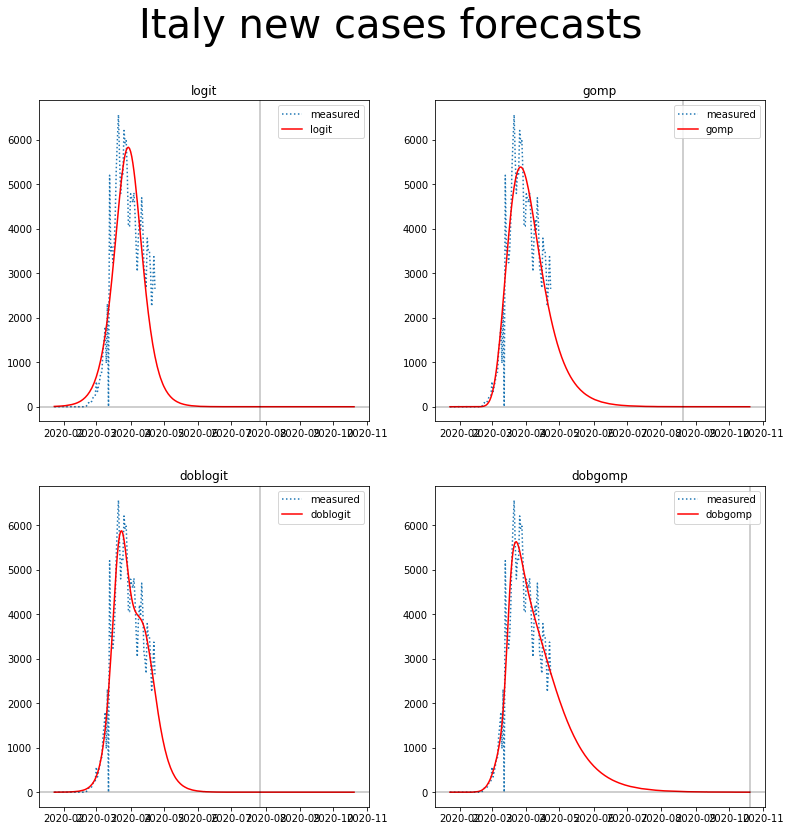

In [155]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, logit1, logit2, new_cases_i, new_cases = prepare_cases(data, forecast=180, country=country, method=f)
    axs.flat[i].plot(
        new_cases["data"],
        new_cases["valore"],
        ls=":",
        label="measured"
    )
    axs.flat[i].plot(
        new_cases_i["data"],
        new_cases_i["valore"],
        c="r",
        label=f
    )
    # axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    axs.flat[i].legend(loc="upper right")
    axs.flat[i].set_title(f)
    axs.flat[i].axhline(0, c="k", alpha=.25)
    news = new_cases_i.iloc[new_cases_i.index > new_cases.size]
    zeros = news.iloc[news["valore"].values == 0]
    zero = zeros["data"].values[0]
    axs.flat[i].axvline(zero, c="k", alpha=.25)
fig.suptitle("Italy new cases forecasts", fontsize=40)

Text(0.5, 0.98, 'Italy deaths forecasts')

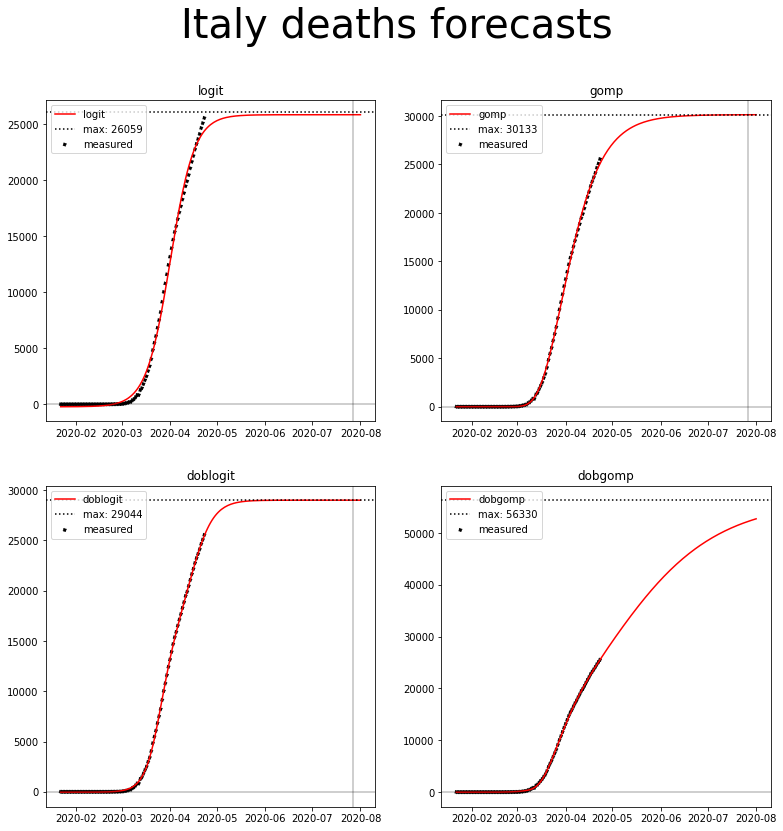

In [166]:
data = get_df(_data, country, what="Deaths")
fig, axs = plt.subplots(2, 2, figsize=(13, 13))

for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, logit1, logit2, new_cases_i, new_cases = prepare_cases(data, forecast=100, country=country, method=f)
    axs.flat[i].scatter(
        original["data"],
        original["valore"],
        ls=":", s=10, c="k",
        label="measured"
    )
    axs.flat[i].plot(
        interp["data"],
        interp["valore"],
        c="r",
        label=f
    )
    axs.flat[i].axhline(max(popt), ls=":", c="k", label=f"max: {max(popt):.0f}")
    try:
        news = new_cases_i.iloc[new_cases_i.index > new_cases.size]
        zeros = news.iloc[news["valore"].values == 0]
        zero = zeros["data"].values[0]
        axs.flat[i].axvline(zero, c="k", alpha=.25)
    except:
        pass
    axs.flat[i].legend(loc="upper left")
    axs.flat[i].set_title(f)
    axs.flat[i].axhline(0, c="k", alpha=.25)
fig.suptitle("Italy deaths forecasts", fontsize=40)

Text(0.5, 0.98, 'Italy new deaths forecasts')

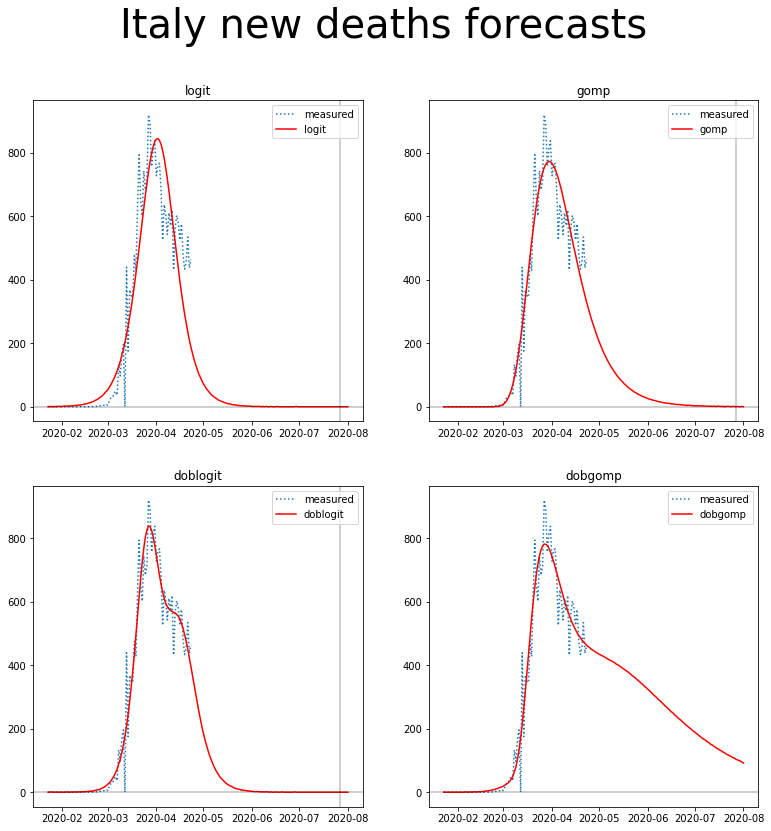

In [164]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13))
for i, f in enumerate(['logit', 'gomp', 'doblogit', 'dobgomp']):
    original, interp, popt, logit1, logit2, new_cases_i, new_cases = prepare_cases(data, forecast=100, country=country, method=f)
    axs.flat[i].plot(
        new_cases["data"],
        new_cases["valore"],
        ls=":",
        label="measured"
    )
    axs.flat[i].plot(
        new_cases_i["data"],
        new_cases_i["valore"],
        c="r",
        label=f
    )
    try:
        news = new_cases_i.iloc[new_cases_i.index > new_cases.size]
        zeros = news.iloc[news["valore"].values == 0]
        zero = zeros["data"].values[0]
        axs.flat[i].axvline(zero, c="k", alpha=.25)
    except:
        pass
    axs.flat[i].legend(loc="upper right")
    axs.flat[i].set_title(f)
    axs.flat[i].axhline(0, c="k", alpha=.25)
fig.suptitle("Italy new deaths forecasts", fontsize=40)

In [26]:
final_results = {}
errors = {"logit": [], "gomp": [], "doblogit": [], "dobgomp": []}

for function in ["logit", "gomp", "doblogit", "dobgomp"]:
    print(function)
    for country in tqdm(_data):
        if country not in final_results:
            final_results.update({country: {}})
        data = get_df(_data, country)
        try:
            original, interp, popt, logit1, logit2 = prepare_cases(data, forecast=0, country=country, method=function)
            if "measured" not in final_results[country]:
                final_results[country].update({"measured": original})
            final_results[country].update({function: interp})
        except Exception as err:
            print(f"\033[43m{country} ERROR: {err}\033[0m")
            final_results[country].update({function: None})
            errors[function].append(country)

logit


/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until



gomp


Eswatini ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Jamaica ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.


/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:117: RuntimeWarning: divide by zero encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


Nepal ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Nigeria ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Saudi Arabia ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Singapore ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.

doblogit


/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Brazil ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Cabo Verde ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Estonia ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Malta ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.

dobgomp


/Users/massimopierini/opt/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


Bangladesh ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Bhutan ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Burma ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Denmark ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Equatorial Guinea ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Iraq ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.
Peru ERROR: Optimal parameters not found: The maximum number of function evaluations is exceeded.



In [27]:
RES = pd.DataFrame(data=final_results)

In [28]:
display(HTML(RES.to_html(notebook=True, col_space=90)))

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cuba,Cyprus,Czechia,Denmark,Diamond Princess,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Equatorial Guinea,Eritrea,Estonia,Eswatini,Ethiopia,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Greece,Grenada,Guatemala,Guinea,Guinea-Bissau,Guyana,Haiti,Holy See,Honduras,Hungary,Iceland,India,Indonesia,Iran,Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,"Korea, South",Kosovo,Kuwait,Kyrgyzstan,Laos,Latvia,Lebanon,Liberia,Libya,Liechtenstein,Lithuania,Luxembourg,MS Zaandam,Madagascar,Malawi,Malaysia,Maldives,Mali,Malta,Mauritania,Mauritius,Mexico,Moldova,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Namibia,Nepal,Netherlands,New Zealand,Nicaragua,Niger,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russia,Rwanda,Saint Kitts and Nevis,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Sao Tome and Principe,Saudi Arabia,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
measured,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 548 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-01-22 0 1 ...,data valore 0 2020-

In [29]:
RES.to_pickle("double-gompertz-data.pkl")